## Stock Price Prediction with Sentiment Analysis

In [1]:
# !pip install charset-normalizer pandas_ta yfinance statsmodels tqdm scikit-learn tensorflow


In [2]:
# To reload the imported modules automatically
%load_ext autoreload
%autoreload 2

In [3]:
# Import necessary libraries and modules
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import warnings
import os

# Import modules
import config as cfg
import data_processing as dp
import sentiment_analysis as sa
import model as mdl
import utils as ut


/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [4]:
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.makedirs(cfg.DATASET_DIR, exist_ok=True)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/sandy/PycharmProjects/stock_market_analysis


In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Set memory growth to be the same for all GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)

    logical_gpus = tf.config.list_logical_devices('GPU')
    print(f"✅ {len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs configured with memory growth.")

  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(f"Error setting memory growth: {e}")
else:
    print("🤷 No GPU detected. TensorFlow will run on CPU.")

✅ 1 Physical GPUs, 1 Logical GPUs configured with memory growth.


I0000 00:00:1753784369.419819   92337 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753784369.419844   92337 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### 1. Load and Analyze News Data

In [6]:
sentiment_csv_path = f"{cfg.DATASET_DIR}/{cfg.STOCK_SYMBOL}_daily_sentiment.csv"

if cfg.UPDATE_SENTIMENT_CSV or not os.path.exists(sentiment_csv_path):
    print("Generating new sentiment data and saving to CSV...")
    news_df = dp.load_and_analyze_news_data(cfg.NEWS_DATA_FILE, cfg.STOCK_SYMBOL)
    company_sentiment_df = sa.process_news_sentiment(news_df, cfg.STOCK_SYMBOL)
    daily_sentiment_df = sa.aggregate_daily_sentiment(company_sentiment_df)
    ut.save_dataframe(daily_sentiment_df, sentiment_csv_path)
else:
    print(f"Loading existing sentiment data from {sentiment_csv_path}...")
    daily_sentiment_df = pd.read_csv(sentiment_csv_path, index_col='Date', parse_dates=True)

print("Sentiment data ready.")

Generating new sentiment data and saving to CSV...
Loading and selecting news data...
File path: Dataset/news_data.csv
Loaded 1400469 articles from Dataset/news_data.csv
\n📰 Processing news sentiment for NVDA...
Initializing sentiment analyzer with model: ProsusAI/finbert
Using device: cpu
Analyzer initialized successfully.
Analyzing 3133 headlines in batches of 32...


  0%|          | 0/98 [00:00<?, ?it/s]

\nSentiment distribution:\n Sentiment
neutral     1573
positive     887
negative     673
Name: count, dtype: int64
\n📊 Aggregating daily sentiment scores...
DataFrame saved to Dataset/NVDA_daily_sentiment.csv
Sentiment data ready.


### 2. Fetch Stock Data and Calculate Technical Indicators

In [7]:
START_DATE, END_DATE = ut.calculate_dynamic_date_range(daily_sentiment_df)

stock_filename = f"{cfg.STOCK_SYMBOL}_stock_data_{START_DATE}_to_{END_DATE}.csv"
stock_csv_path = os.path.join(cfg.DATASET_DIR, stock_filename)

if cfg.UPDATE_STOCK_CSV or not os.path.exists(stock_csv_path):
    print(f"Fetching new stock data from yfinance ({START_DATE} to {END_DATE})...")
    stock_data = dp.fetch_stock_data(cfg.STOCK_SYMBOL, START_DATE, END_DATE)
    if stock_data is not None:
        stock_data.to_csv(stock_csv_path)
        print(f"Stock data saved to {stock_csv_path}")
else:
    print(f"Loading existing stock data from {stock_csv_path}...")
    stock_data = pd.read_csv(stock_csv_path, index_col='Date', parse_dates=True)

# Calculate technical indicators from the loaded/fetched data
tech_data = dp.calculate_technical_indicators(stock_data)
print("Technical indicators calculated.")

Fetching new stock data from yfinance (2010-03-03 to 2020-06-10)...
\n📈 Fetching stock data for NVDA...
Successfully fetched 2586 days of data.
Stock data saved to Dataset/NVDA_stock_data_2010-03-03_to_2020-06-10.csv
Technical indicators calculated.


### 3. Prepare Data for LSTM & SVM Models

In [8]:
# Prepare data for models using only technical indicators
X_train_tech, X_test_tech, y_train_tech, y_test_tech, scaler_tech = mdl.prepare_data_for_lstm(
    tech_data, cfg.BASELINE_FEATURES, cfg.BASELINE_TARGET, cfg.SEQUENCE_LENGTH, cfg.TEST_SIZE
)

# Prepare data for models using sentiment + technical indicators
enhanced_full_data = dp.create_enhanced_dataset(tech_data, daily_sentiment_df)
X_train_enh, X_test_enh, y_train_enh, y_test_enh, scaler_enh = mdl.prepare_data_for_lstm(
    enhanced_full_data, cfg.ENHANCED_FEATURES, cfg.ENHANCED_TARGET, cfg.SEQUENCE_LENGTH, cfg.TEST_SIZE
)


🔗 Merging sentiment and technical data...
Enhanced dataset shape: (2387, 29)


### 4. Run LSTM Models

In [9]:
print("\n--- Running Baseline LSTM Model (Single-Layer) ---")
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=0)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

baseline_model = mdl.build_single_layer_lstm((X_train_tech.shape[1], X_train_tech.shape[2]))
baseline_history = baseline_model.fit(
    X_train_tech, y_train_tech, epochs=cfg.EPOCHS, batch_size=cfg.BATCH_SIZE,
    validation_split=0.2, callbacks=[reduce_lr, early_stopping], verbose=0
)
print("Baseline LSTM training complete.")


--- Running Baseline LSTM Model (Single-Layer) ---
Baseline LSTM training complete.


Plot saved to Output/NVDA_Baseline_LSTM_analysis.png


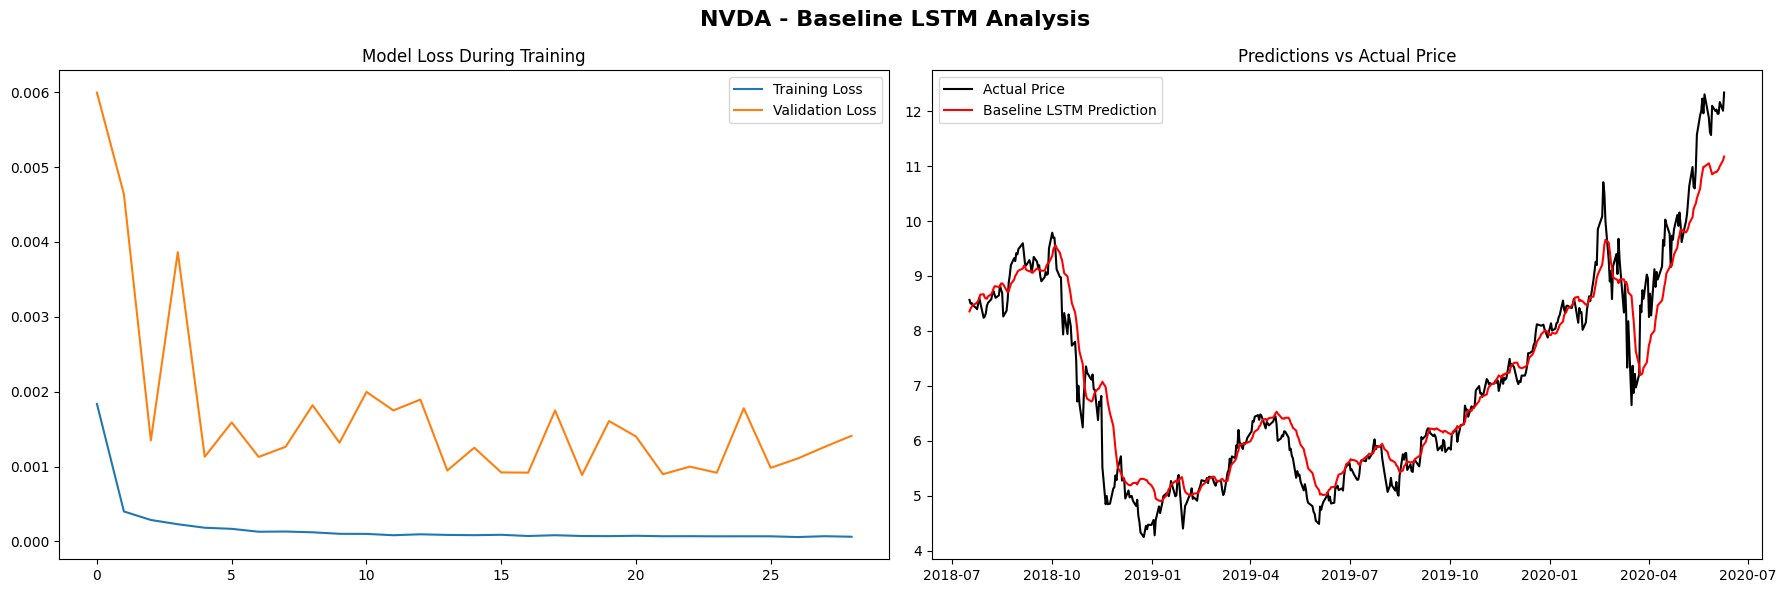

In [10]:
base_preds = baseline_model.predict(X_test_tech, verbose=0)
close_scaler = MinMaxScaler().fit(tech_data[['Close']]) # Use a simple scaler for just the target column
y_test_tech_scaled = close_scaler.inverse_transform(y_test_tech.reshape(-1, 1))
base_preds_scaled = close_scaler.inverse_transform(base_preds)
baseline_metrics = ut.calculate_metrics(y_test_tech_scaled, base_preds_scaled, 'Baseline LSTM')
test_dates_tech = tech_data.index[-len(y_test_tech_scaled):]
ut.plot_model_results(baseline_history, y_test_tech_scaled, base_preds_scaled, test_dates_tech, cfg.STOCK_SYMBOL, 'Baseline LSTM')

In [11]:
print("\n--- Running Multi-Layer LSTM Model ---")
multi_layer_model = mdl.build_multi_layer_lstm((X_train_tech.shape[1], X_train_tech.shape[2]))
multi_layer_history = multi_layer_model.fit(
    X_train_tech, y_train_tech, epochs=cfg.EPOCHS, batch_size=cfg.BATCH_SIZE,
    validation_split=0.2, callbacks=[reduce_lr, early_stopping], verbose=0
)
print("Multi-Layer LSTM training complete.")


--- Running Multi-Layer LSTM Model ---
Multi-Layer LSTM training complete.


Plot saved to Output/NVDA_Multi-Layer_LSTM_analysis.png


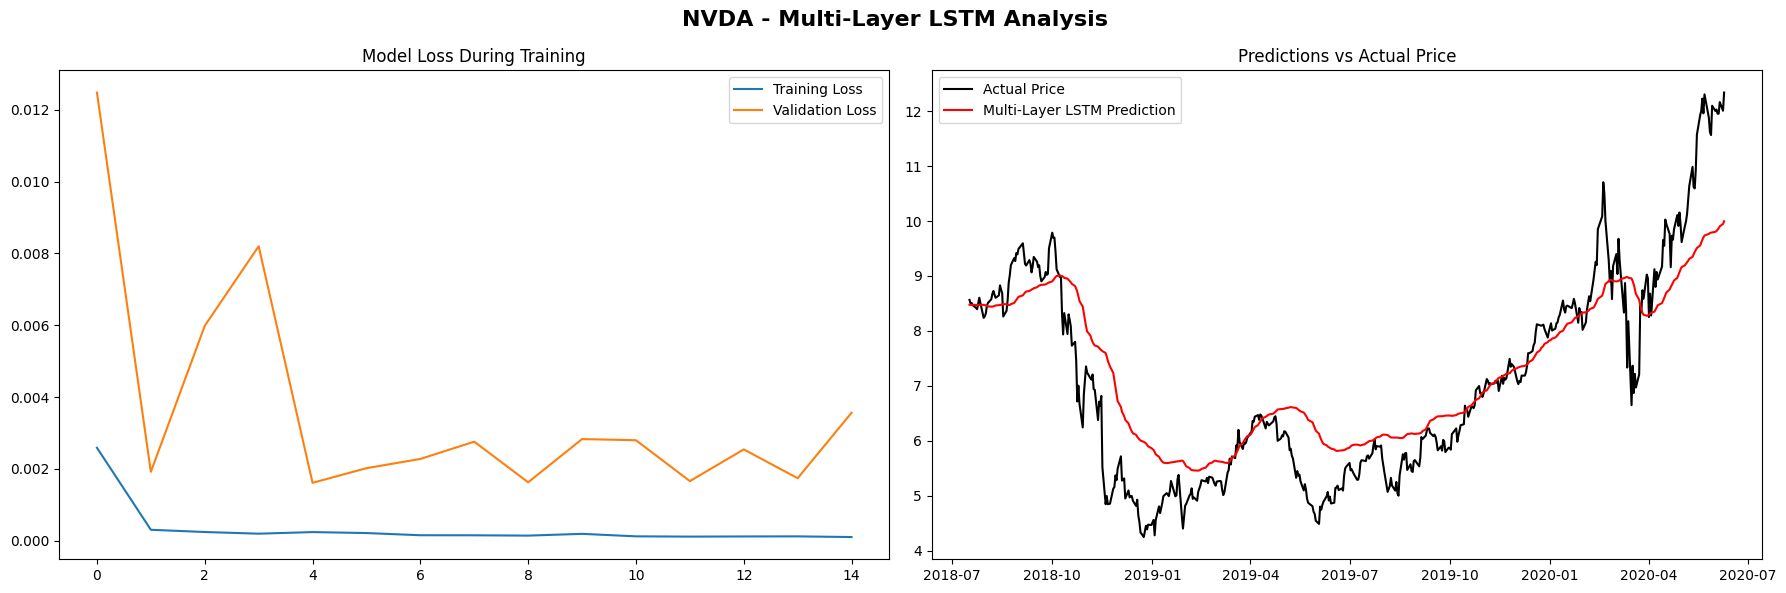

In [12]:
multi_preds = multi_layer_model.predict(X_test_tech, verbose=0)
multi_preds_scaled = close_scaler.inverse_transform(multi_preds)
multi_layer_metrics = ut.calculate_metrics(y_test_tech_scaled, multi_preds_scaled, 'Multi-Layer LSTM')
ut.plot_model_results(multi_layer_history, y_test_tech_scaled, multi_preds_scaled, test_dates_tech, cfg.STOCK_SYMBOL, 'Multi-Layer LSTM')

In [13]:
print("\n--- Running Enhanced LSTM Model (Single-Layer) ---")
enhanced_model = mdl.build_single_layer_lstm((X_train_enh.shape[1], X_train_enh.shape[2]))
enhanced_history = enhanced_model.fit(
    X_train_enh, y_train_enh, epochs=cfg.EPOCHS, batch_size=cfg.BATCH_SIZE,
    validation_split=0.2, callbacks=[reduce_lr, early_stopping], verbose=0
)
print("Enhanced LSTM training complete.")


--- Running Enhanced LSTM Model (Single-Layer) ---
Enhanced LSTM training complete.


Plot saved to Output/NVDA_Enhanced_LSTM_analysis.png


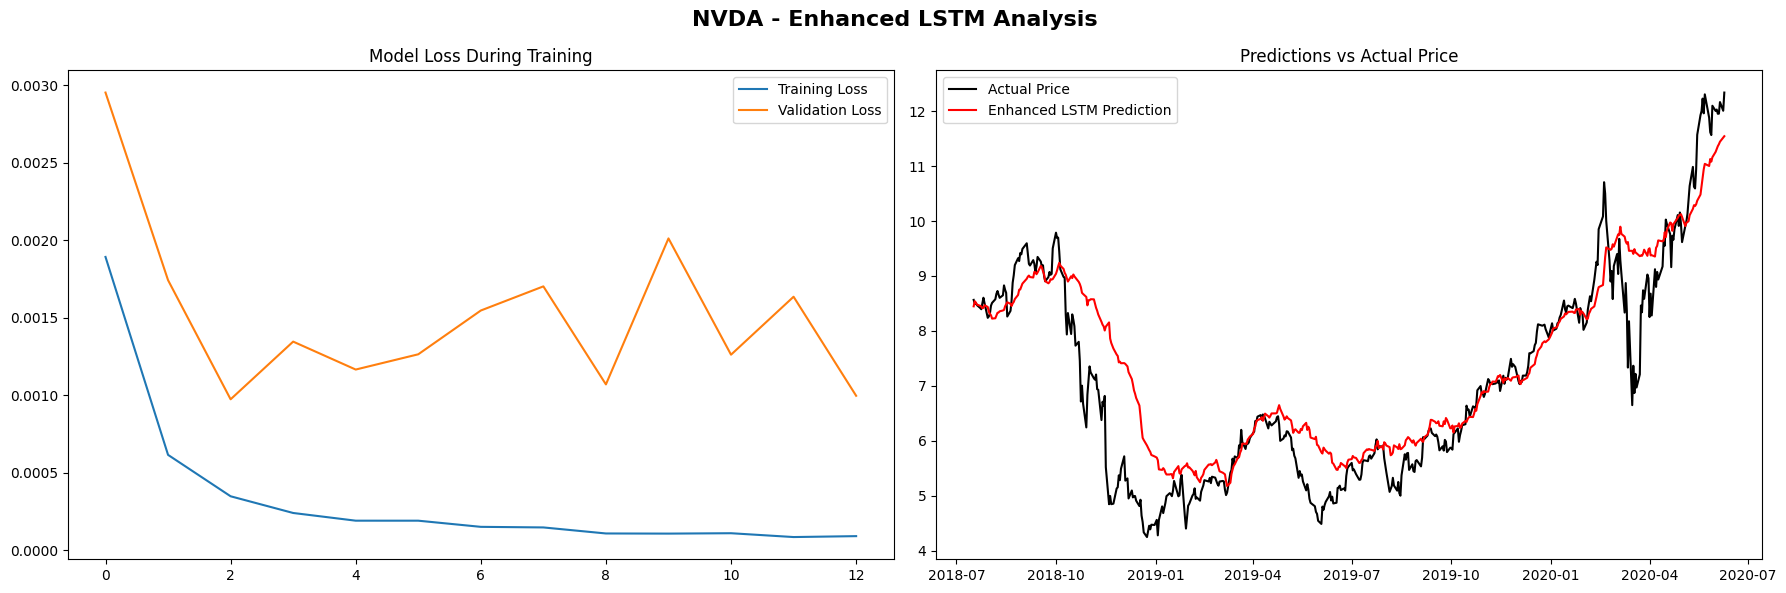

In [14]:
enh_preds = enhanced_model.predict(X_test_enh, verbose=0)
close_scaler_enh = MinMaxScaler().fit(enhanced_full_data[['Close']])
y_test_enh_scaled = close_scaler_enh.inverse_transform(y_test_enh.reshape(-1, 1))
enh_preds_scaled = close_scaler_enh.inverse_transform(enh_preds)
enhanced_metrics = ut.calculate_metrics(y_test_enh_scaled, enh_preds_scaled, 'Enhanced LSTM')
test_dates_enh = enhanced_full_data.index[-len(y_test_enh_scaled):]
ut.plot_model_results(enhanced_history, y_test_enh_scaled, enh_preds_scaled, test_dates_enh, cfg.STOCK_SYMBOL, 'Enhanced LSTM')

In [15]:
print("\n--- Running Multi-Layer Enhanced LSTM Model ---")
multi_enhanced_model = mdl.build_multi_layer_lstm((X_train_enh.shape[1], X_train_enh.shape[2]))
multi_enhanced_history = multi_enhanced_model.fit(
    X_train_enh, y_train_enh, epochs=cfg.EPOCHS, batch_size=cfg.BATCH_SIZE,
    validation_split=0.2, callbacks=[reduce_lr, early_stopping], verbose=0
)
print("Multi-Layer Enhanced LSTM training complete.")


--- Running Multi-Layer Enhanced LSTM Model ---
Multi-Layer Enhanced LSTM training complete.


Plot saved to Output/NVDA_Multi-Layer_Enhanced_LSTM_analysis.png


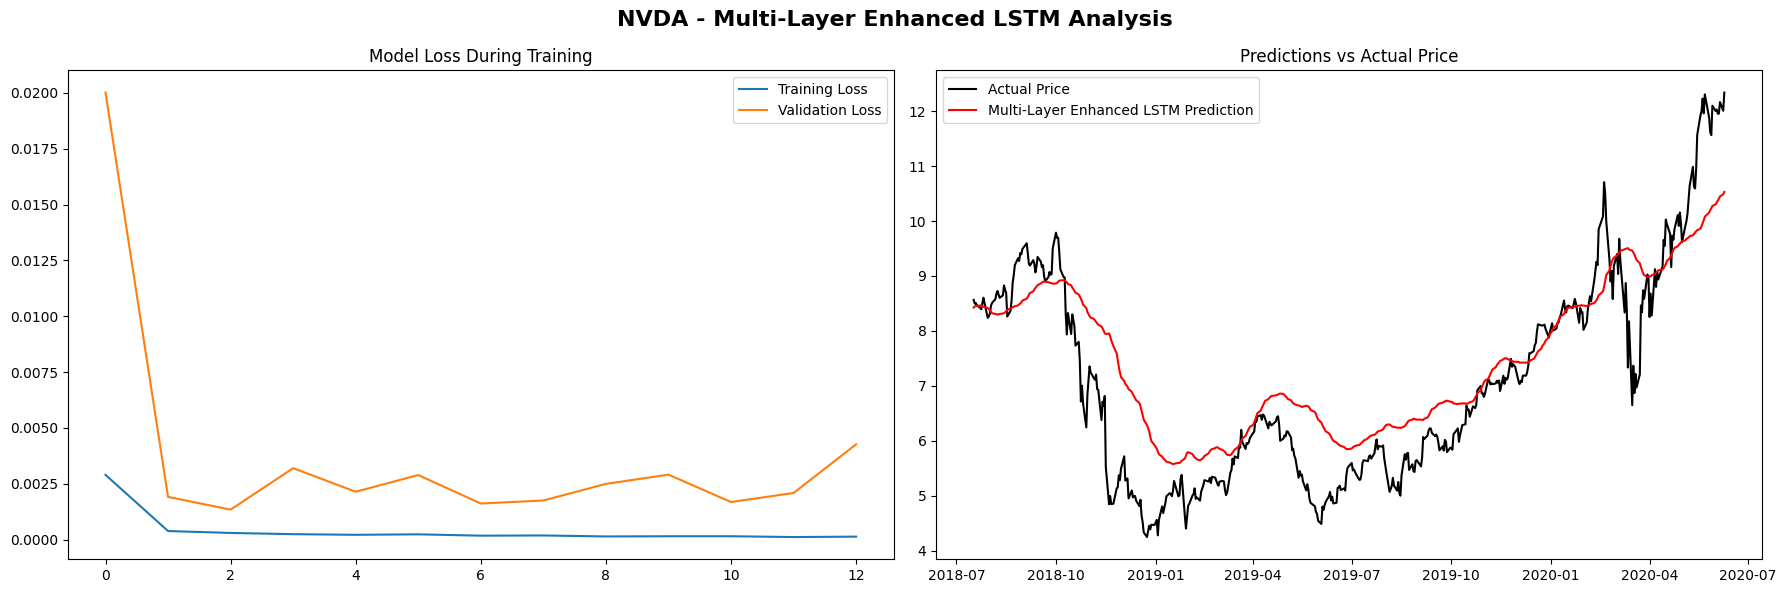

In [16]:
multi_enh_preds = multi_enhanced_model.predict(X_test_enh, verbose=0)
multi_enh_preds_scaled = close_scaler_enh.inverse_transform(multi_enh_preds)
multi_enhanced_metrics = ut.calculate_metrics(y_test_enh_scaled, multi_enh_preds_scaled, 'Multi-Layer Enhanced LSTM')
ut.plot_model_results(multi_enhanced_history, y_test_enh_scaled, multi_enh_preds_scaled, test_dates_enh, cfg.STOCK_SYMBOL, 'Multi-Layer Enhanced LSTM')

### 5. Run Support Vector Machine (SVM) Models --- (NEW)

In [17]:
print("\n--- Preparing Data for SVM ---")
# SVM requires 2D input, so we flatten the sequence data
nsamples, nx, ny = X_train_tech.shape
X_train_svm_tech = X_train_tech.reshape((nsamples, nx * ny))

nsamples, nx, ny = X_test_tech.shape
X_test_svm_tech = X_test_tech.reshape((nsamples, nx * ny))

print(f"Reshaped baseline data for SVM: {X_train_svm_tech.shape}")


--- Preparing Data for SVM ---
Reshaped baseline data for SVM: (1819, 630)


Building and training SVM model...
SVM training complete.
Plot saved to Output/NVDA_Baseline_SVM_analysis.png


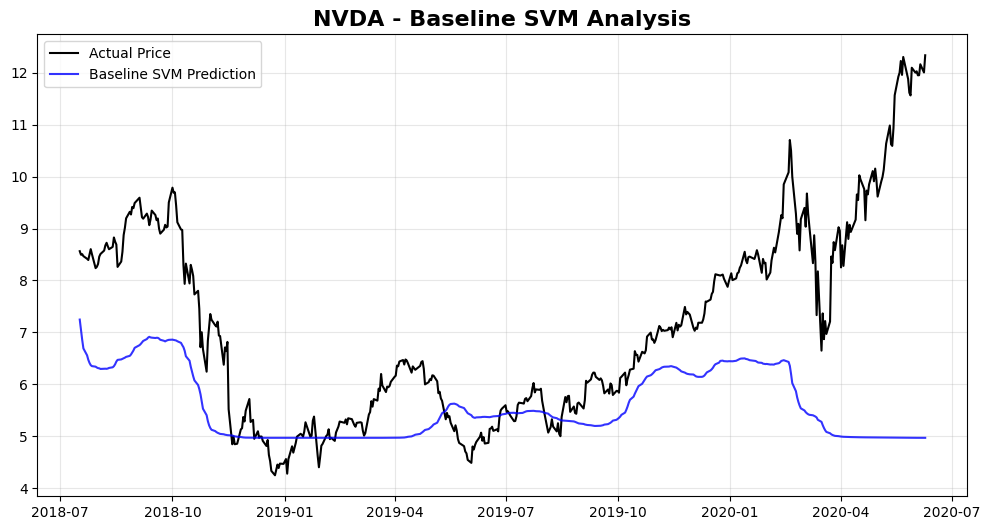

In [18]:
baseline_svm_model = mdl.build_and_train_svm(X_train_svm_tech, y_train_tech)
base_svm_preds = baseline_svm_model.predict(X_test_svm_tech)

base_svm_preds_scaled = close_scaler.inverse_transform(base_svm_preds.reshape(-1, 1))
baseline_svm_metrics = ut.calculate_metrics(y_test_tech_scaled, base_svm_preds_scaled, 'Baseline SVM')
ut.plot_non_keras_results(y_test_tech_scaled, base_svm_preds_scaled, test_dates_tech, cfg.STOCK_SYMBOL, 'Baseline SVM')


--- Preparing Enhanced Data for SVM ---
Reshaped enhanced data for SVM: (1819, 900)
Building and training SVM model...
SVM training complete.
Plot saved to Output/NVDA_Enhanced_SVM_analysis.png


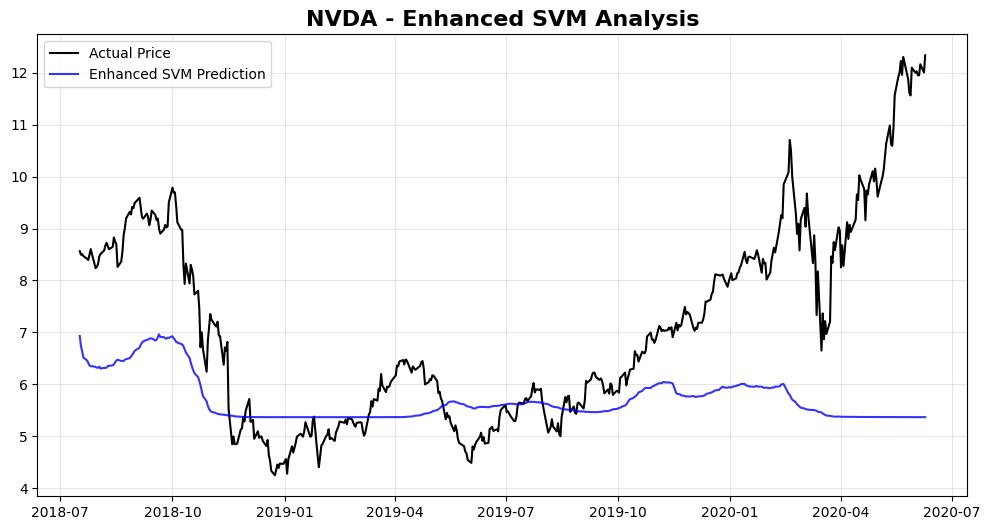

In [19]:
print("\n--- Preparing Enhanced Data for SVM ---")
# Reshape the enhanced data
nsamples, nx, ny = X_train_enh.shape
X_train_svm_enh = X_train_enh.reshape((nsamples, nx * ny))

nsamples, nx, ny = X_test_enh.shape
X_test_svm_enh = X_test_enh.reshape((nsamples, nx * ny))

print(f"Reshaped enhanced data for SVM: {X_train_svm_enh.shape}")

enhanced_svm_model = mdl.build_and_train_svm(X_train_svm_enh, y_train_enh)
enh_svm_preds = enhanced_svm_model.predict(X_test_svm_enh)

enh_svm_preds_scaled = close_scaler_enh.inverse_transform(enh_svm_preds.reshape(-1, 1))
enhanced_svm_metrics = ut.calculate_metrics(y_test_enh_scaled, enh_svm_preds_scaled, 'Enhanced SVM')
ut.plot_non_keras_results(y_test_enh_scaled, enh_svm_preds_scaled, test_dates_enh, cfg.STOCK_SYMBOL, 'Enhanced SVM')

### 6. ARIMA Model


--- Running ARIMA Model ---
Performing rolling forecast for 478 steps...
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training complete.
Building and training ARIMA model...
ARIMA training comple

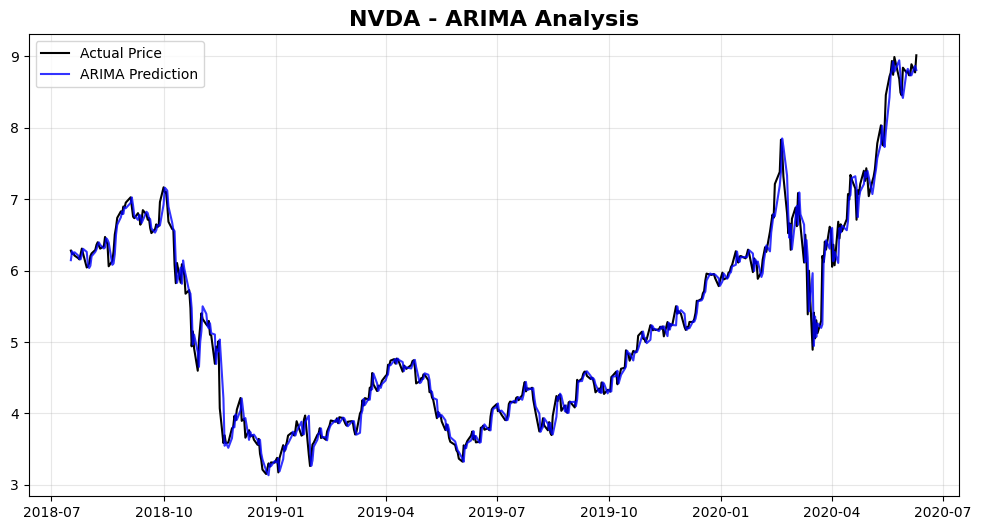

In [20]:
print("\n--- Running ARIMA Model ---")
# ARIMA works on the unscaled, 1D time series of the target variable
close_prices = tech_data[cfg.BASELINE_TARGET]
train_size = int(len(close_prices) * (1 - cfg.TEST_SIZE))
train_arima, test_arima = close_prices[0:train_size], close_prices[train_size:]

history = [x for x in train_arima]
arima_predictions = []

print(f"Performing rolling forecast for {len(test_arima)} steps...")
for t in range(len(test_arima)):
    model_arima = mdl.build_and_train_arima(history)
    output = model_arima.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test_arima[t]
    history.append(obs)

arima_predictions_np = np.array(arima_predictions).reshape(-1, 1)
y_test_arima_np = np.array(test_arima).reshape(-1, 1)
arima_metrics = ut.calculate_metrics(y_test_arima_np, arima_predictions_np, 'ARIMA')
ut.plot_non_keras_results(y_test_arima_np, arima_predictions_np, test_arima.index, cfg.STOCK_SYMBOL, 'ARIMA')

### 7. Final Performance Comparison

In [21]:
naive_preds = np.roll(y_test_tech_scaled, 1)
naive_preds[0] = y_test_tech_scaled[0]
naive_metrics = ut.calculate_metrics(y_test_tech_scaled, naive_preds, 'Naive Baseline')

# --- UPDATED TO INCLUDE ALL MODELS ---
all_metrics_df = pd.DataFrame([
    naive_metrics,
    baseline_metrics,
    enhanced_metrics,
    multi_layer_metrics,
    multi_enhanced_metrics,
    baseline_svm_metrics,
    enhanced_svm_metrics,
    arima_metrics
]).round(4)

print("\n📊 COMPREHENSIVE PERFORMANCE COMPARISON")
print("-" * 60)
print(all_metrics_df.to_string(index=False))
print("-" * 60)

metrics_to_evaluate = {
    'RMSE': 'min',
    'MAE': 'min',
    'Directional_Accuracy': 'max'
}

print("\n🏆 Best Model for Each Metric")
print("-" * 30)
for metric, method in metrics_to_evaluate.items():
    if method == 'min':
        winner_idx = all_metrics_df[metric].idxmin()
    else:
        winner_idx = all_metrics_df[metric].idxmax()
    winner_row = all_metrics_df.loc[winner_idx]
    print(f"{metric:<22}: {winner_row['Model']} (Score: {winner_row[metric]:.4f})")


📊 COMPREHENSIVE PERFORMANCE COMPARISON
------------------------------------------------------------
                    Model   RMSE    MAE  Directional_Accuracy
           Naive Baseline 0.2531 0.1700               44.0252
            Baseline LSTM 0.5051 0.3434               49.4759
            Enhanced LSTM 0.8223 0.5529               48.4277
         Multi-Layer LSTM 0.8804 0.6485               51.1530
Multi-Layer Enhanced LSTM 0.9465 0.7152               50.5241
             Baseline SVM 2.3189 1.6206               52.4109
             Enhanced SVM 2.2596 1.6210               52.2013
                    ARIMA 0.1834 0.1223               44.8637
------------------------------------------------------------

🏆 Best Model for Each Metric
------------------------------
RMSE                  : ARIMA (Score: 0.1834)
MAE                   : ARIMA (Score: 0.1223)
Directional_Accuracy  : Baseline SVM (Score: 52.4109)


In [22]:
ranking_df = all_metrics_df.copy()

ranking_df['RMSE_Rank'] = ranking_df['RMSE'].rank(method='min', ascending=True)
ranking_df['MAE_Rank'] = ranking_df['MAE'].rank(method='min', ascending=True)


ranking_df['DA_Rank'] = ranking_df['Directional_Accuracy'].rank(method='min', ascending=False)

ranking_df['Total_Rank'] = ranking_df['RMSE_Rank'] + ranking_df['MAE_Rank'] + ranking_df['DA_Rank']

final_ranking = ranking_df.sort_values(by='Total_Rank', ascending=True)

print("-" * 40)
print("\\n🏆 Overall Model Ranking (Best to Worst)")
print("-" * 40)
print(final_ranking[['Model', 'Total_Rank', 'RMSE', 'Directional_Accuracy']].reset_index(drop=True).to_string())

----------------------------------------
\n🏆 Overall Model Ranking (Best to Worst)
----------------------------------------
                       Model  Total_Rank    RMSE  Directional_Accuracy
0                      ARIMA         9.0  0.1834               44.8637
1              Baseline LSTM        11.0  0.5051               49.4759
2             Naive Baseline        12.0  0.2531               44.0252
3           Multi-Layer LSTM        13.0  0.8804               51.1530
4              Enhanced LSTM        14.0  0.8223               48.4277
5  Multi-Layer Enhanced LSTM        16.0  0.9465               50.5241
6               Baseline SVM        16.0  2.3189               52.4109
7               Enhanced SVM        17.0  2.2596               52.2013


Plot saved to Output/NVDA_all_models_comparison.png


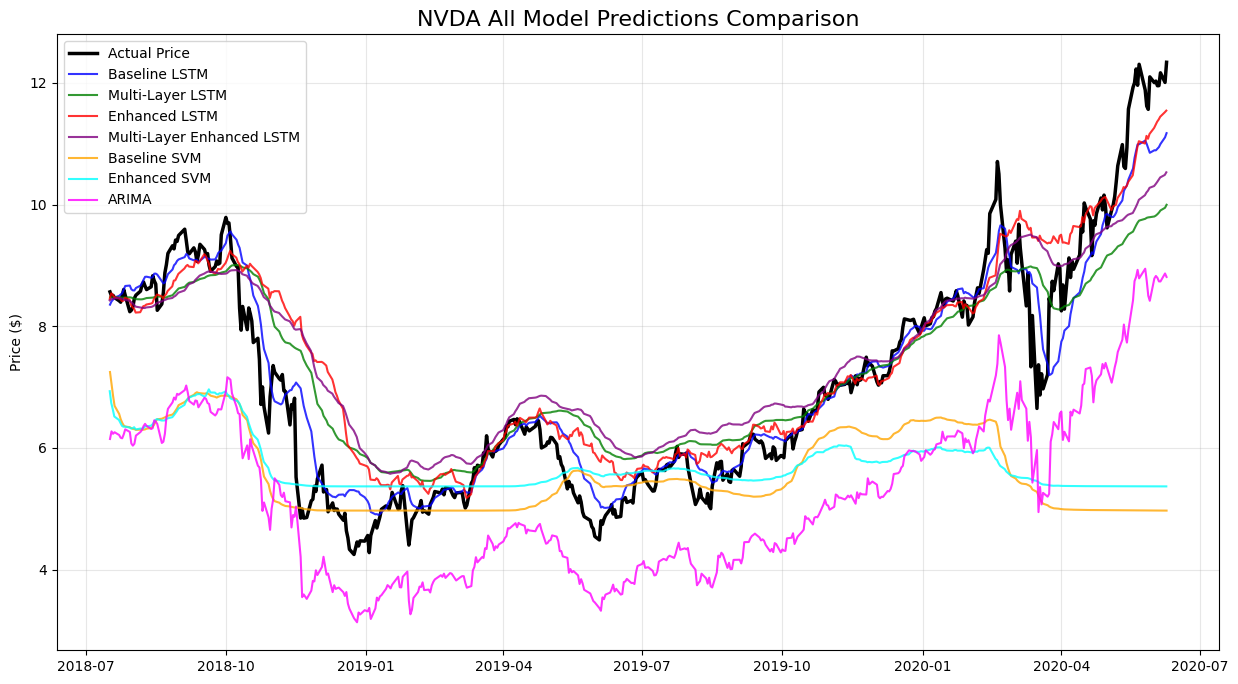

In [24]:
plot_data = {
    'Actual': {'dates': test_dates_tech, 'values': y_test_tech_scaled},
    'Baseline LSTM': {'dates': test_dates_tech, 'values': base_preds_scaled},
    'Multi-Layer LSTM': {'dates': test_dates_tech, 'values': multi_preds_scaled},
    'Enhanced LSTM': {'dates': test_dates_enh, 'values': enh_preds_scaled},
    'Multi-Layer Enhanced LSTM': {'dates': test_dates_enh, 'values': multi_enh_preds_scaled},
    'Baseline SVM': {'dates': test_dates_tech, 'values': base_svm_preds_scaled},
    'Enhanced SVM': {'dates': test_dates_enh, 'values': enh_svm_preds_scaled},
    'ARIMA': {'dates': test_arima.index, 'values': arima_predictions_np}
}

ut.plot_final_comparison(plot_data, cfg.STOCK_SYMBOL)